# Métodos

## Carga Google Drive

In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

## Importar Tensorflow

In [41]:
# !pip install tensorflow-addons

In [42]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.layers import Input, Lambda, Activation, Conv2D, MaxPooling2D, BatchNormalization, Add, concatenate, Conv2DTranspose, Flatten

In [43]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvidia-smi

Found GPU at: /device:GPU:0
Mon Apr  4 13:14:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8    N/A /  N/A |   3544MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

2022-04-04 13:14:55.050351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 13:14:55.050680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 computeCapability: 6.1
coreClock: 1.493GHz coreCount: 5 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2022-04-04 13:14:55.050799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 13:14:55.051112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 13:14:55.051382: I tensorflow/core/common

## Importador/Exportador Feature Weights

In [44]:
import json

def write_weights(feature_vector, root_path, file_name):
    with open(root_path + file_name, 'w') as outfile:
        json.dump(feature_vector, outfile)

def load_weights(root_path, file_name):
    with open(root_path + file_name) as json_file:
        data = json.load(json_file)

    return data

## Construcción de imágenes

In [45]:
import numpy as np
import math
from matplotlib import pyplot as plt

def get_feature_matrix_indexes(sorted_feature_vector,matrix):  

    half_row = round((matrix.shape[0] - 1) / 2)
    half_column = round((matrix.shape[1] - 1) / 2)

    matrix_indexes = {}
    
    index = 0

    for parent_key in sorted_feature_vector:
        normalized_index = math.ceil(index/2)

        if (index % 2 != 0): # Impar
            current_row = half_row - normalized_index
        else: # Par
            current_row = half_row + normalized_index

        sorted_child_indexes = np.argsort(feature_vector[parent_key]['feature_weights'])[::-1]

        child_names   = np.array(feature_vector[parent_key]['feature_childs'])
        child_weights = np.array(feature_vector[parent_key]['feature_weights'])

        sorted_child_names   = child_names[sorted_child_indexes]
        sorted_child_weights = child_weights[sorted_child_indexes]

        position = 0
        for sorted_child_index in sorted_child_indexes:
            normalized_position = math.ceil(position/2)

            if (position % 2 != 0): # Impar
                current_column = half_column - normalized_position
            else: # Par
                current_column = half_column + normalized_position

            matrix_indexes[child_names[sorted_child_index]] = [current_row, current_column]
            position = position + 1 

        index = index + 1

    return matrix_indexes
    
def fv2gi(feature_vector):

    max_dimension = 0
    for key in feature_vector:
        childs_number = len(feature_vector[key]['feature_childs'])
        max_dimension = max(childs_number, max_dimension)
                
    matrix = np.zeros((max_dimension, max_dimension))

    weights_vector = []
    for parent_key in feature_vector:
        wpi = sum([float(child_weight) for child_weight in feature_vector[parent_key]['feature_weights']])
        feature_vector[parent_key]['wpi'] = wpi
        weights_vector.append(wpi)

   
    sorted_feature_vector = sorted(feature_vector.items(),
                                   key = lambda item: item[1]['wpi'],
                                   reverse = True)
     
    sorted_feature_vector = dict(sorted_feature_vector)

    
    matrix_indexes = get_feature_matrix_indexes(sorted_feature_vector, matrix)

    return matrix_indexes

# matrix_indexes = fv2gi(feature_vector)

## Construcción Feature Vector

In [46]:
def fill_feature_vector(X_dataset,child_weights):
  # Obtenemos el set de columnas del dataset
  train_columns_set  = set(X_dataset.columns)

  for parent_feature in feature_vector.keys():
    # Obtiene el set de características hijas del padre actual
    # dict.fromleys para mantener el orden, un set desordena los valores
    feature_childs_set = dict.fromkeys(feature_vector[parent_feature]['feature_childs'])

    # Obtener el índice de las columnas del actual padre para acceder a los pesos del XGBoost
    index_feature_childs = X_dataset.columns.get_indexer(feature_childs_set)

    feature_vector[parent_feature]['feature_weights'] = list([str(child_weight) for child_weight in child_weights[index_feature_childs]])

  return feature_vector

## Normalización de datos

In [47]:
from scipy.stats import zscore
import pandas as pd

def normalize_data(X_data):

    # Create a sample df
    normalized_df = X_data

    # Calculate the zscores and drop zscores into new column
    for column in normalized_df.columns:
        normalized_df[column] = zscore(normalized_df[column])
    
    return normalized_df

## Oversampling de datos

In [48]:
from imblearn.over_sampling import BorderlineSMOTE

def oversample_data(X_data, Y_labels):

    oversample = BorderlineSMOTE(kind='borderline-2')
    X_oversampled, Y_oversampled = oversample.fit_resample(X_data, Y_labels)

    print('********** After OverSampling **********')
    print('Slight: ', (Y_oversampled == 'Slight').sum())
    print('Serious:', (Y_oversampled == 'Serious').sum())
    print('Fatal:  ', (Y_oversampled == 'Fatal').sum())
    print('\n Total X: ', len(X_oversampled), ' Total Y: ', len(Y_oversampled))

    return X_oversampled, Y_oversampled

## Construcción de imágenes

In [49]:
def build_gray_images(dataset, max_dimension, matrix_indexes):

    matrix_3d = np.zeros((max_dimension, max_dimension, len(dataset.index)))
    print(len(dataset.index))
    for feature, value in matrix_indexes.items():
        matrix_3d[value[0], value[1],] = dataset[feature]
        
    return matrix_3d

## Reshape de imágenes

In [50]:
# Add one channel
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

# Add one channel to gray images depending of the number of the data
def shape_images(X_data, gray_images):
  images = []

  for i in range(0,len(X_data)):
      original_matrix = gray_images[:,:,i]
      # print(original_matrix.shape)
      shaped_image = np.expand_dims(original_matrix, axis=2)
      # print(shaped_image.shape)
      images.append(shaped_image)
      # plt.matshow(shaped_image)

  return images

## One-Hot Encoder/Decoder

In [51]:
def casualty_to_one_hot(Y_labels):

    transf = {
        'Slight': 0,
        'Serious': 1,
        'Fatal': 2
    }

    Y_labels.replace(transf, inplace = True)

    return tf.one_hot(Y_labels, 3)

def one_hot_to_casualty(Y_labels):

    transf = {
        0: 'Slight',
        1: 'Serious',
        2: 'Fatal'
    }   

    return Y_labels.replace(transf)

## Visualización de datos

### Matriz de correlación

In [52]:
import seaborn as sns

def correlation_matrix(X_data):
    corrMatrix = X_data.corr()
    fig,ax  = plt.subplots(1,1,figsize=(15,10))
    sns.heatmap(corrMatrix, annot=True)
    plt.show()

### PCA

In [53]:
from sklearn.decomposition import PCA

def pca(X_train_data, X_test_data):
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train_data)
    X_test_pca  = pca.transform(X_test_data)
    explained_variance = pca.explained_variance_ratio_

    figure_name = plt.figure(figsize=(15, 10))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

### TSNE

In [54]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name = None):

    X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components = n_components).fit_transform(X_data_scaled)

    # X_test_scaled = StandardScaler().fit_transform(X_test),
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled),

    palette = sns.color_palette('husl', 3)
    fig,ax  = plt.subplots(1,1,figsize=(15,10))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full')

    if (output_file_name): plt.savefig('./Out/' + output_file_name)

### Autoencoder

In [55]:
def autoencoder ():
    input_img = Input(shape=(25,))

    # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
    encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
    encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

    # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
    decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
    decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

    # this model maps an input to its reconstruction
    autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
    autoencoder.summary()

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas
    
    return autoencoder

## TASP-CNN

In [56]:
import tensorflow_addons as tfa

lr_init = 0.1
num_classes = 3

tasp_cnn = models.Sequential()
tasp_cnn.add(layers.Conv2D(256, (3, 3),strides=(1, 1), activation='relu', padding='same', input_shape=(5, 5, 1)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())
tasp_cnn.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(3, 3, 256)))
tasp_cnn.add(layers.BatchNormalization())  
tasp_cnn.add(layers.Flatten())
tasp_cnn.add(layers.Dense(units=128))
tasp_cnn.add(layers.Dense(3, activation='softmax'))

tasp_cnn.compile(
    optimizer=Adam(learning_rate = lr_init, epsilon=1e-06),
    loss='categorical_crossentropy',
    metrics=[tfa.metrics.F1Score(num_classes = num_classes, average='micro', threshold=0.1)]
  )

In [57]:
print('Done!')

Done!


# Leeds Data

## Importación de datos

In [ ]:
# !conda install pandas --y

In [ ]:
import pandas as pd
# https://datamillnorth.org/dataset/road-traffic-accidents
# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/TFM_DATA/'

root_path = './Data/Leeds/'

file_path_2009 = './2009.csv'
file_path_2010 = './2010.csv'
file_path_2011 = './2011.csv'
file_path_2012 = './2012.csv'
file_path_2013 = './2013.csv'
file_path_2014 = './2014.csv'
file_path_2015 = './2015.csv'
file_path_2016 = './2016.csv'

file_2009 = pd.read_csv(root_path + file_path_2009, encoding = 'cp1252')
file_2010 = pd.read_csv(root_path + file_path_2010, encoding = 'cp1252')
file_2011 = pd.read_csv(root_path + file_path_2011, encoding = 'cp1252')
file_2012 = pd.read_csv(root_path + file_path_2012, encoding = 'cp1252')
file_2013 = pd.read_csv(root_path + file_path_2013, encoding = 'cp1252')
file_2014 = pd.read_csv(root_path + file_path_2014, encoding = 'cp1252')
file_2015 = pd.read_csv(root_path + file_path_2015, encoding = 'cp1252')
file_2016 = pd.read_csv(root_path + file_path_2016, encoding = 'cp1252')

###################### UNIÓN DE ARCHIVOS ######################

a = pd.concat([file_2009,file_2010])

file_2013 = clean_df = file_2013.loc[:, ~file_2013.columns.isin(['Casualty Class'])]
file_2013.set_axis(a.columns, axis=1, inplace=True)
                                             
file_2014 = clean_df = file_2014.loc[:, ~file_2014.columns.isin(['Casualty Class'])]
file_2014.set_axis(a.columns, axis=1, inplace=True)

# file_2015 = clean_df = file_2015.loc[:, ~file_2015.columns.isin(['Casualty Class'])]
file_2015.set_axis(a.columns, axis=1, inplace=True)
file_2016 = clean_df = file_2016.loc[:, ~file_2016.columns.isin(['Expr1'])]
file_2016.set_axis(a.columns, axis=1, inplace=True)

a = pd.concat([a, file_2011])
a = pd.concat([a, file_2012])
a = pd.concat([a, file_2013])
a = pd.concat([a, file_2014])
a = pd.concat([a, file_2015])
a = pd.concat([a, file_2016])

# a['1st Road Class'].value_counts()

## Limpieza de datos

In [ ]:
###################### DICCIONARIOS DE REEMPLAZO ######################
# Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# A, A(M) y Motorway lo mismo?
# B:            De carácter regional y utilizado para conectar zonas de menor importancia.
#               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
#               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
#               ¿Carretera como tal?

# C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
#               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.
road_class_replace = {
    'Motorway': 1,
    'A(M)': 2,
    'A': 3,
    'B': 4,
    'C': 5,
    'Unclassified': 6
}

##################################
accident_date_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost / Ice': 4,
    'Flood': 5,
}
##################################

road_surface_replace = {
    'Dry': 1,
    'Wet / Damp': 2,
    'Snow': 3,
    'Frost/ Ice': 4,
    'Frost / Ice': 4,
    'Flood': 5,
    'Flood (surface water over 3cm deep)': 5,
    '5': 5
}

# La 5: "Darkness: street lighting unknown" no está presente en el paper, le hemos puesto un 5 porque sí #
lighting_conditions_replace = {
    'Daylight: street lights present': 1,
    'Darkness: no street lighting': 2,
    'Darkness: street lights present and lit': 3,
    'Darkness: street lights present but unlit': 4,
    'Darkness: street lighting unknown': 5,
    '5': 5
}

# La 8.2: "Unknown" no está presente en el paper, le hemos puesto un 8 porque sí (Other) #
weather_conditions_replace = {
    'Fine without high winds': 1,
    'Raining without high winds': 2,
    'Snowing without high winds': 3,
    'Fine with high winds': 4,
    'Raining with high winds': 5,
    'Snowing with high winds': 6,
    'Fog or mist – if hazard': 7,
    'Other': 8,
    'Unknown': 8
}

type_of_vehicle_replace = {
    'Pedal cycle': 1,
    'M/cycle 50cc and under': 2,
    'Motorcycle over 50cc and up to 125cc': 3,
    'Motorcycle over 125cc and up to 500cc': 4,
    'Motorcycle over 500cc': 5,
    'Taxi/Private hire car': 6,
    'Car': 7,
    'Minibus (8 – 16 passenger seats)': 8,
    'Bus or coach (17 or more passenger seats)': 9,
    'Ridden horse': 10,
    'Agricultural vehicle (includes diggers etc.)': 11,
    'Tram / Light rail': 12,
    'Goods vehicle 3.5 tonnes mgw and under': 13,
    'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw': 14,
    'Goods vehicle 7.5 tonnes mgw and over': 15,
    'Mobility Scooter': 16,
    'Other Vehicle ': 17,
    'Motorcycle - Unknown CC': 18
}

casualty_class_replace = {
    'Driver': 1,
    'Driver/Rider': 1,
    'Driver or rider': 1,
    'Passenger': 2,
    'Vehicle or pillion passenger': 2,
    'Pedestrian': 3
}


sex_of_casualty_replace = {
    'Male': 1,
    'Female': 2
}

###################### REEMPLAZOS ######################
clean_df = clean_df.dropna()

a['1st Road Class'].replace(road_class_replace, inplace = True)
# print('1st Road Class:', a['1st Road Class'].unique())

##################################
# a['Accident Date'].replace(accident_date_replace, inplace = True)
# print('Accident Date:', a['Accident Date'].unique())
##################################
a['Road Surface'].replace(road_surface_replace, inplace = True)
a.dropna(inplace = True)

a['Road Surface'] = a['Road Surface'].astype('int')
# print('Road Surface:', a['Road Surface'].unique())

a['Lighting Conditions'].replace(lighting_conditions_replace, inplace = True)
# print('Lighting Conditions:', a['Lighting Conditions'].unique())

a['Weather Conditions'].replace(weather_conditions_replace, inplace = True)
a = a[a['Weather Conditions'] != 'Darkness: street lighting unknown']
# print('Weather Conditions:', a['Weather Conditions'].unique())

a['Type of Vehicle'].replace(type_of_vehicle_replace, inplace = True)
# print('Type of Vehicle:', a['Type of Vehicle'].unique())

a['Casualty Class'].replace(casualty_class_replace, inplace = True)
# print('Casualty Class:', a['Casualty Class'].unique())

a['Sex of Casualty'].replace(sex_of_casualty_replace, inplace = True)
# print('Sex of Casualty:', a['Sex of Casualty'].unique())

a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] < 18, 1)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(18, 25), 2)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'].between(25, 65), 3)
a['Age of Casualty'] = a['Age of Casualty'].mask(a['Age of Casualty'] > 65, 4)
# print('Age of Casualty:', a['Age of Casualty'].unique())

a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] < 600, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'] > 1800, 2)
a['Time (24hr)'] = a['Time (24hr)'].mask(a['Time (24hr)'].between(600, 1800), 1)
# print('Time (24hr):', a['Time (24hr)'].unique())
a.rename(columns={"Time (24hr)": "Accident Time"}, inplace = True)

###################### LIMPIEZA DE VALORES NULOS/DUPLICADOS ######################

clean_df = a.loc[:, ~a.columns.isin(['Accident Date', 'Reference Number'])]

clean_df['Weather Conditions'] = clean_df['Weather Conditions'].astype('int')
clean_df['Casualty Class']     = clean_df['Casualty Class'].astype('int')

clean_df = clean_df.drop_duplicates()
clean_df = clean_df.dropna()
clean_df = clean_df.reset_index(drop=True)

clean_df

## Split de datos

In [ ]:
# !conda install scikit-learn --y

In [ ]:
from sklearn.model_selection import train_test_split

Y = clean_df['Casualty Severity']

train, test = train_test_split(clean_df, test_size=0.2)
X_train = train.loc[:, ~train.columns.isin(['Casualty Severity'])]
Y_train = train['Casualty Severity']

X_test = test.loc[:, ~test.columns.isin(['Casualty Severity'])]
Y_test = test['Casualty Severity']

In [ ]:
# fv2gi(feature_vector)
# sorted(feature_vector.items(), key = lambda item: item[0][1])

# for item in feature_vector['Accident Features'].items():
#     print(item[1])

# feature_vector[parent_key].items()

# sorted(feature_vector['Accident Features'].items(), key = lambda item: item,
#                                reverse = True)

# print(feature_vector['Accident Features']['feature_weights'])

# fv = np.array(feature_vector['Accident Features']['feature_childs'])
# list(fv[indexes])

## Normalización de datos

In [ ]:
# !conda install -c conda-forge imbalanced-learn

In [ ]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)

## Oversamplig de datos

In [ ]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

## Pesos XGBoost

### Carga de pesos

In [ ]:
FILE_PATH = './XGBoost_Weights/'
# FILE_NAME = 'leeds_calculated_weights.json'
FILE_NAME = 'leeds_default_weights.json'

feature_vector = load_weights(FILE_PATH, FILE_NAME)
display(feature_vector)

### Cálculo

In [ ]:
# from numpy import loadtxt
# from xgboost import XGBClassifier,XGBRanker
# from matplotlib import pyplot
# from xgboost import plot_importance

# X_data = pd.concat([X_train,X_test])
# Y_data = pd.concat([Y_train,Y_test])

# n_trees = 1000
# booster = 'gbtree'
# importance_type = 'weight'

# xgboost = XGBClassifier(n_estimators = n_trees,
#                         booster = booster,
#                         importance_type = importance_type)

# xgboost.fit(X_train, Y_train)

# child_weights  = np.array(xgboost.feature_importances_)
# feature_vector = fill_feature_vector(X_train, child_weights)

### Visualización pesos calculados

In [ ]:
# print(xgboost.get_booster().get_score(importance_type= 'weight'))
# plt.figure(figsize=(10, 5))
# plt.barh(X_train.columns, xgboost.feature_importances_)
# print(xgboost.feature_importances_)

# for column, weight in zip(X_train.columns,xgboost.feature_importances_):
#   print(column, weight)

### Escritura

In [ ]:
# FILE_PATH = './XGBoost_Weights/'
# FILE_NAME = 'leeds_calculated_weights.json'
# # FILE_NAME = 'leeds_default_weights.json'

# write_weights(feature_vector, FILE_PATH, FILE_NAME)

### Cálculo índices de matriz

In [ ]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [ ]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
test_bgi  = build_gray_images(X_test, 5, matrix_indexes)

pd.DataFrame(train_bgi[:,:,1057])

## Reshape de imágenes

In [ ]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)

In [ ]:
plt.gray()
for i in range(0,3):
    plt.figure(figsize=(3, 3))
    plt.imshow(train_bgi[:,:,i])
    plt.show()

In [ ]:
# !conda install scikit-image

In [ ]:
from skimage.feature import hog
resized_img = train_bgi[:,:,1]

for i in range(0,3):
  fd, hog_image = hog(train_bgi[:,:,i], orientations=9, pixels_per_cell=(2, 2),
                    cells_per_block=(2, 2), visualize=True)
  plt.figure(figsize=(3, 3))
  plt.imshow(hog_image)
  plt.show()

In [ ]:
# input_shape = (5, 5)

array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

In [ ]:
# !conda install -c conda-forge tensorflow 

In [ ]:
######### EN TERMINAL #########
# !pip install tensorflow-addons

## One-Hot

In [ ]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_test_onehot  = casualty_to_one_hot(Y_test)

## Visualización de datos

In [ ]:
# !conda install seaborn

### Matriz de correlación

In [ ]:
# correlation_matrix(X_test)

### PCA

In [ ]:
# pca(X_train, X_test)

### TSNE

In [ ]:
# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

### Autoencoder

#### Entrenamiento

In [ ]:
X_train = array_train_images
X_test = array_test_images

X_train = X_train.reshape(len(array_train_images), 25)
X_test  = X_test.reshape(len(X_test), 25)

# autoencoder().fit(X_train, X_train,
#                 epochs=15,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [ ]:
# # create encoder model
# encoder = Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# color=['red','green','blue']

# for x, y, z, label in zip(xs, ys, zs, Y_test):
#     c = color[int(label)]
#     ax.text(x, y, z, label, backgroundcolor=c)
    
# ax.set_xlim(xs.min(), xs.max())
# ax.set_ylim(ys.min(), ys.max())
# ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

def plot_TSNE(X_data, Y_data, n_components, output_file_name=None):
    X_data_scaled = StandardScaler().fit_transform(X_data)
    z_data = TSNE(n_components=n_components).fit_transform(X_data_scaled)
    # X_test_scaled = StandardScaler().fit_transform(X_test)
    # z_test = TSNE(n_components=2).fit_transform(X_test_scaled)

    palette = sns.color_palette("hls", 3)
    fig,ax  = plt.subplots(1,1,figsize=(15,10))
    sns.scatterplot(x = z_data[:,0],
                    y = z_data[:,1],
                    hue = Y_data,
                    palette = palette,
                    legend = 'full')

    if (output_file_name): plt.savefig('./Out/' + output_file_name)

# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

## TASP-CNN

### Entrenamiento

In [ ]:
input_train_shape = (len(array_train_images), 5, 5, 1)
input_test_shape = (len(array_test_images), 5, 5, 1)

array_train_images.reshape(input_train_shape)
array_test_images.reshape(input_test_shape)

# history = tasp_cnn.fit(array_train_images, Y_train_onehot,
#                     batch_size = 128, epochs = 100, shuffle = True,
#                     validation_data = (array_test_images, Y_test_onehot))

# tasp_cnn.save(root_path + 'model.h5')

# history

### Carga de modelo pre-entrenado

In [ ]:
# tasp_cnn = tf.keras.models.load_model(root_path + 'model.h5')

### Resultados

In [ ]:
# from sklearn.metrics import classification_report

# Y_labels = one_hot_to_casualty(Y_test)

# ########################################################################

# # Plot history: F1 SCORE
# # figure_name = plt.figure(figsize=(20, 10))
# # plt.plot(history.history['f1_score'], label='F1 score (training data)')
# # plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
# # plt.title('F1 score')
# # plt.ylabel('F1 score value')
# # plt.xlabel('No. epoch')
# # plt.legend(loc="upper left")
# # plt.savefig('./conv-conv.jpg')
# # plt.show()

# # print(history)

# ########################################################################

# # evaluate the network
# print("[INFO] evaluating network...")
# predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)
# print(classification_report(tf.argmax(Y_test_onehot, axis=1),
# 	                          predictions.argmax(axis=1),
#                             target_names = Y_labels.unique()))

In [ ]:
# import tensorflow as tf
# from sklearn.metrics import classification_report

# predictions = xgboost.predict(X_test)
# predictions

In [ ]:
# prediction_string = [str(prediction) for prediction in predictions]
# pd.DataFrame(prediction_string).value_counts()

# Madrid Data

## Importación de datos

- [Web Dataset](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=7c2843010d9c3610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)

- [Web documentación](https://datos.madrid.es/FWProjects/egob/Catalogo/Seguridad/Ficheros/Estructura_DS_Accidentes_trafico_desde_2019.pdf)



In [58]:
import pandas as pd

MODEL_VERSION = '_v7'

# root_path = '/content/drive/Othercomputers/Mi portátil/Drive/Master UA/TFM/Incidentes de Trafico/Datasets/Madrid/'

root_path = './Data/Madrid/'

file_name_2019 = '2019_Accidentalidad.csv'
file_name_2020 = '2020_Accidentalidad.csv'
file_name_2021 = '2021_Accidentalidad.csv'
file_name_2022 = '2022_Accidentalidad.csv'

file_2019 = pd.read_csv(root_path + file_name_2019, sep=';')
file_2020 = pd.read_csv(root_path + file_name_2020, sep=';')
file_2021 = pd.read_csv(root_path + file_name_2021, sep=';')
file_2022 = pd.read_csv(root_path + file_name_2022, sep=';')

# print(len(file_2019[file_2019.cod_lesividad == 4]))
# print(len(file_2020[file_2020.cod_lesividad == 4]))
# print(len(file_2021[file_2021.lesividad == '4']))
# print(len(file_2022[file_2022.lesividad == '4']))

COLUMNS_TO_REMOVE = ['cod_distrito',
                     'tipo_lesividad'
                    ]

data_frame = file_2019
data_frame = pd.concat([data_frame, file_2020])

data_frame.rename(columns={"cod_lesividad": "lesividad"}, inplace = True)
data_frame.rename(columns={"tipo_vehículo": "tipo_vehiculo"}, inplace = True)
data_frame = data_frame.drop(COLUMNS_TO_REMOVE, axis=1)

data_frame = pd.concat([data_frame, file_2021])

data_frame.dropna(subset=['lesividad'], inplace = True)
data_frame.lesividad = data_frame.lesividad.replace(' ', 14).astype(int)
data_frame = data_frame.reset_index(drop=True)

### Calcular Vehículos implicados

A partir del número de expediente (un mismo expediente en varias filas quiere decir que se trata del mismo accidente) se hace un `groupby` a partir de él. Como el atributo `positiva_alcohol` no tiene valores nulos en ninguna de las filas, hacemos un conteo a partir de él y se asigna a una nueva columna `positiva_alcohol_rename` que posteriormente será renombrada como `vehiculos_implicados`

In [59]:
data_frame = data_frame.join(data_frame.groupby('num_expediente')['positiva_alcohol'].count(), on='num_expediente', rsuffix='_rename')
data_frame.rename(columns={"positiva_alcohol_rename": "vehiculos_implicados"}, errors="raise", inplace=True)
data_frame = data_frame.reset_index(drop=True)

## Limpieza de datos

### Clasificación de carreteras

In [60]:
######################### SIGUIENTE CELDA #########################

# Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# A, A(M) y Motorway lo mismo?
# B:            De carácter regional y utilizado para conectar zonas de menor importancia.
#               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
#               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
#               ¿Carretera como tal?

# C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
#               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# Unclassified


regex = {}
regex['paseo_regex'] = 'PASEO|paseo'
regex['parque_regex'] = 'PARQUE|PQUE'
regex['ronda_regex'] = 'RONDA'
regex['puerta_regex'] = 'PUERTA|PTA|Puerta'
regex['puente_regex'] = 'PNTE|PUENTE'
regex['plaza_regex'] = 'PLAZA|PZA'
regex['camino_regex']= 'CMNO|CAMINO'
regex['bulevard_regex'] = 'BULE'
regex['travesia_regex'] = 'TRVA'
regex['cuesta_regex'] = 'CUSTA|CUESTA'
regex['rotonda_regex'] = 'GTA|gta|GLORIETA|glorieta|ROTONDA'
regex['aeropuerto_regex'] ='AEROPUERTO|AEROP'
regex['calzada_regex'] = 'CALZADA'
regex['poligono_regex'] ='POLIGONO'
regex['highway_regex'] = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
regex['road_regex'] = 'CTRA.|CARRETERA|carretera|CRA.' # B
regex['avenida_regex'] = 'AVDA|AV|AVENIDA|AVDA|Avda.|avenida'
regex['calle_regex']  = 'CALL.|Calle|CALLE|c/|C/|C.|calle'

data_frame['tipo_via'] = 'N/A'

for index,regex_values in enumerate(regex.values()):
    print(regex_values)
    regex_indexes = data_frame[data_frame.localizacion.str.contains(regex_values,  case = True, regex=True)].index
    print(len(regex_indexes))
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('tipo_via')] = str(index)
    data_frame.iloc[regex_indexes, data_frame.columns.get_loc('localizacion')] = str(index)
    
    
    
# street_indexes  = data_frame[data_frame.localizacion.str.contains('CALL.|Calle|CALLE|c/|C/|C.|calle', case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

PASEO|paseo
5683
PARQUE|PQUE
205
RONDA
446
PUERTA|PTA|Puerta
154
PNTE|PUENTE
188
PLAZA|PZA
2464
CMNO|CAMINO
823
BULE
82
TRVA
102
CUSTA|CUESTA
218
GTA|gta|GLORIETA|glorieta|ROTONDA
1397
AEROPUERTO|AEROP
163
CALZADA
1747
POLIGONO
4
AUTOV.|autovia|A-|M-|M 30|m 30|A\d|M 23|M23
5684
CTRA.|CARRETERA|carretera|CRA.
766
AVDA|AV|AVENIDA|AVDA|Avda.|avenida
13080
CALL.|Calle|CALLE|c/|C/|C.|calle
27596


In [61]:
data_frame.tipo_via.value_counts()

17    27596
16    13080
14     5684
0      5683
5      2464
12     1747
10     1397
6       823
15      766
2       446
9       218
1       205
4       188
11      163
3       154
8       102
7        82
13        4
Name: tipo_via, dtype: int64

In [62]:
# ######################### SIGUIENTE CELDA #########################

# # Unclassified: Carreteras locales sin destino definido. Sin embargo, los destinos locales pueden estar señalizados a lo largo de ellos.
# # A, A(M) y Motorway lo mismo?
# # B:            De carácter regional y utilizado para conectar zonas de menor importancia.
# #               Por lo general, se muestran de color marrón o amarillo en los mapas y tienen las mismas señales blancas que las rutas de clase A que no son primarias.
# #               Si la ruta es primaria, como la B6261, se mostrará igual que una ruta Clase A primaria.
# #               ¿Carretera como tal?

# # C:            Designaciones de autoridades locales para rutas dentro de su área con fines administrativos.
# #               Estas rutas no se muestran en mapas de carreteras a pequeña escala, pero se sabe que ocasionalmente aparecen en las señales de tráfico.

# # Unclassified
# street_regex  = ('CALL.|Calle|CALLE|c/|C/|C.|calle|'
#                  'AVDA|AV|AVENIDA|AVDA|avenida|Avda.|'
#                  'PASEO|paseo|'
#                  'PARQUE|PQUE|'
#                  'RONDA|'
#                  'PUERTA|PTA|Puerta|'
#                  'PNTE|PUENTE|'
#                  'PLAZA|PZA|'
#                  'CMNO|CAMINO|'
#                  'BULE|'
#                  'TRVA|'
#                  'CUSTA|CUESTA|'
#                  'GTA|gta|GLORIETA|glorieta|ROTONDA|'
#                  'AEROPUERTO|AEROP'
# )

# highway_regex = 'AUTOV.|autovia|A-|M-|M 30|m 30|A\\d|M 23|M23' # A,A(M),Motorway
# road_regex = 'CTRA.|CARRETERA|carretera|CRA.|CALZADA|POLIGONO' # B

# street_indexes  = data_frame[data_frame.localizacion.str.contains(street_regex,  case = True, regex=True)].index
# highway_indexes = data_frame[data_frame.localizacion.str.contains(highway_regex, case = True, regex=True)].index
# road_indexes    = data_frame[data_frame.localizacion.str.contains(road_regex, case = True, regex=True)].index
# # avenue_indexes  = data_frame[data_frame.localizacion.str.contains(avenue_regex,  case = True, regex=True)].index
# # ride_indexes    = data_frame[data_frame.localizacion.str.contains(ride_regex, case = True, regex=True)].index

# data_frame['tipo_via'] = 'N/A'

# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('tipo_via')] = 'Unclassified'
# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('tipo_via')] = 'A'
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('tipo_via')] = 'B'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('tipo_via')] = 'AVENIDA'


# data_frame.iloc[highway_indexes, data_frame.columns.get_loc('localizacion')] = 1
# data_frame.iloc[road_indexes, data_frame.columns.get_loc('localizacion')] = 2
# data_frame.iloc[street_indexes,  data_frame.columns.get_loc('localizacion')] = 3
# # data_frame.iloc[avenue_indexes,  data_frame.columns.get_loc('localizacion')] = '3'
# # data_frame.iloc[ride_indexes, data_frame.columns.get_loc('localizacion')] = '5'

# positive_drug_indexes = data_frame[data_frame.positiva_droga == 1].index
# data_frame.iloc[positive_drug_indexes, data_frame.columns.get_loc('positiva_alcohol')] = 'S'

# data_frame = data_frame[~(data_frame.tipo_via == 'N/A')]
# # print(data_frame.localizacion.unique())

Consideraciones:

- Los patinetes se han considerado como ciclomotres de menos de 50cc.
- Las furgonetas se consideran como vehículos de menos de 3.5 toneladas.
- Maquinaria de obras se considera la misma tipología que maquinaria agrícola.
- Cuadriciclos ligeros y no ligeros se consideran como `Motorcycle-Unknown CC`.
- Patinetes y Vehículos de Mobilidad Urbana se consideran como `Mobility Scooters`.
- `Vehículo articulado` se considera como un vehículo de más de 7.5 toneladas.

In [63]:
weather_conditions_replace = {
    'Despejado': 1,
    'Nublado': 2,
    'Lluvia débil': 3,
    'LLuvia intensa': 4,
    'Granizando':  5,
    'Nevando': 6,
    'Se desconoce': 7 
}

## CUIDADO CON Motocicleta hasta 125cc!!! HEMOS SUPUESTO QUE LOS CICLOMOTORES SON HASTA 50CC!!
type_of_vehicle_replace = {
    'Bicicleta': 1,
    'Ciclo': 1,
    'Bicicleta EPAC (pedaleo asistido)': 1,
    'Ciclomotor': 2,
    'Ciclomotor de dos ruedas L1e-B': 2,
    'Ciclomotor de tres ruedas': 2,
    'Motocicleta hasta 125cc': 3,
    'Moto de tres ruedas hasta 125cc': 3,
    'Motocicleta > 125cc': 4,
    'Moto de tres ruedas > 125cc': 4,
    'Turismo': 5,
    'Todo terreno': 5,
    'Microbús <= 17 plazas': 5,
    'Autobús': 6,
    'Autobus EMT': 6,
    'Autobús articulado': 6,
    'Autobús articulado EMT': 6,
    'Maquinaria agrícola': 7,
    'Maquinaria de obras': 8,
    'Furgoneta': 9,        # Menos de 3.5 toneladas.
    'Ambulancia SAMUR': 10,
    'Autocaravana': 11,     # Entre 3.5 y 7.5 toneladas.
    'Camión rígido': 12,    # Mayor que 7.5 toneladas.
    'Tractocamión': 12,
    'Vehículo articulado': 12,
    'Camión de bomberos': 12,
    'VMU eléctrico': 13,
    'Patinete': 13,
    'Sin especificar': 14,
    'Otros vehículos sin motor': 14,
    'Remolque': 14,
    'Semiremolque': 14,
    'Otros vehículos con motor': 15,
    'Cuadriciclo ligero': 15,
    'Cuadriciclo no ligero': 15,
    'Motorcycle - Unknown CC': 15
}

# type_of_vehicle_replace = {}
# for index,tipo_vehiculo in enumerate(data_frame.tipo_vehiculo.unique()):
#     if not pd.isna(tipo_vehiculo): type_of_vehicle_replace[tipo_vehiculo] = index

casualty_class_replace = {
    'Conductor': 1,
    'Pasajero': 2,
    'Peatón': 3
}

### CUIDADO CON DESCONOCIDO!!! MEJOR HACER IMPUTACIÓN PARA RELLENENAR LOS DESCONOCIDOS?
sex_of_casualty_replace = {
    'Hombre': 1,
    'Mujer': 2,
    'Desconocido': 3
}

accident_type_replace = {
    'Colisión fronto-lateral': 1,
    'Alcance': 2,
    'Colisión lateral': 3,
    'Choque contra obstáculo fijo': 4,
    'Colisión múltiple': 5,
    'Caída': 5,
    'Atropello a persona': 6,
    'Colisión frontal': 7,
    'Otro': 8,
    'Solo salida de la vía': 9,
    'Vuelco': 10,
    'Atropello a animal': 11,
    'Despeñamiento': 12
}

alcohol_replace = {
    'S': 1,
    'N': 2,
}

accident_class_replace = {
    1:  'Slight',  # Atención en urgencias sin posterior ingreso. - LEVE
    2:  'Slight',  # Ingreso inferior o igual a 24 horas - LEVE
    5:  'Slight',  # Asistencia sanitaria ambulatoria con posterioridad - LEVE
    6:  'Slight',  # Asistencia sanitaria inmediata en centro de salud o mutua - LEVE
    7:  'Slight',  # Asistencia sanitaria sólo en el lugar del accidente - LEVE
    14: 'Slight',  # Sin asistencia sanitaria - LEVE O NADA
    3:  'Serious', # Ingreso superior a 24 horas. - GRAVE
    4:  'Fatal'    # Fallecido 24 horas - FALLECIDO 
}
###################### REEMPLAZOS ######################

# ### OJO QUE ESTAMOS REPLICANDO LA ESTRUCTURA DEL DATASET DE LEEDS
age_replace = {
    'Menor de 5 años': 1,
    'De 6 a 9 años': 1,
    'De 6  a  9 años': 1,
    'De 10 a 14 años': 1,
    'De 15 a 17 años': 1,
    'De 18 a 20 años': 2,
    'De 21 a 24 años': 2,
    'De 25 a 29 años': 3,
    'De 30 a 34 años': 3,
    'De 35 a 39 años': 3,
    'De 40 a 44 años': 3,
    'De 45 a 49 años': 3,
    'De 50 a 54 años': 3,
    'De 55 a 59 años': 3,
    'De 60 a 64 años': 3,
    'De 65 a 69 años': 4,
    'De 70 a 74 años': 4,
    'Más de 74 años': 4,
    'Desconocido': 5,
}

### OJO QUE ESTAMOS REPLICANDO LA ESTRUCTURA DEL DATASET DE LEEDS
# age_replace = {
#     'Menor de 5 años': 1,
#     'De 6 a 9 años': 2,
#     'De 6  a  9 años': 3,
#     'De 10 a 14 años': 4,
#     'De 15 a 17 años': 5,
#     'De 18 a 20 años': 6,
#     'De 21 a 24 años': 7,
#     'De 25 a 29 años': 8,
#     'De 30 a 34 años': 9,
#     'De 35 a 39 años': 10,
#     'De 40 a 44 años': 11,
#     'De 45 a 49 años': 12,
#     'De 50 a 54 años': 13,
#     'De 55 a 59 años': 14,
#     'De 60 a 64 años': 15,
#     'De 65 a 69 años': 16,
#     'De 70 a 74 años': 17,
#     'Más de 74 años': 18,
#     'Desconocido': 19,
# }

data_frame['estado_meteorológico'].replace(weather_conditions_replace, inplace = True)
print('Estado meteorológico: \n', data_frame['estado_meteorológico'].value_counts())

data_frame['tipo_vehiculo'].replace(type_of_vehicle_replace, inplace = True)
print('Tipo vehículo: \n', data_frame['tipo_vehiculo'].value_counts())

data_frame['tipo_persona'].replace(casualty_class_replace, inplace = True)
print('Tipo de persona: \n', data_frame['tipo_persona'].value_counts())

data_frame['sexo'].replace(sex_of_casualty_replace, inplace = True)
print('Sexo: \n', data_frame['sexo'].value_counts())

data_frame['positiva_alcohol'].replace(alcohol_replace, inplace = True)
print('Positivo Alcohol: \n', data_frame['positiva_alcohol'].value_counts())

data_frame['lesividad'].replace(accident_class_replace, inplace = True)
print('Gravedad: \n', data_frame['lesividad'].value_counts())

data_frame['rango_edad'].replace(age_replace, inplace = True)
print('Edad: \n', data_frame['rango_edad'].value_counts())

data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) < '06:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora) > '18:00:00', 2)
data_frame.hora = data_frame.hora.mask(pd.to_datetime(data_frame.hora).between('06:00:00', '18:00:00'), 1)
print('hora:', data_frame['hora'].value_counts())

district_replace = {}
for index,distrito in enumerate(data_frame.distrito.unique()):
  if not pd.isna(distrito): district_replace[distrito] = int(index)

accident_type_replace = {}
for index,accident_type in enumerate(data_frame.tipo_accidente.unique()):
    if not pd.isna(accident_type): accident_type_replace[accident_type] = int(index)

data_frame['distrito'].replace(district_replace, inplace = True)
print('Distrito: \n', data_frame['distrito'].value_counts())

data_frame['tipo_accidente'].replace(accident_type_replace, inplace = True)
print('Tipo Accidente: \n', data_frame['tipo_accidente'].value_counts())

# Eliminamos aquellas lesividades desconocidas i.e. 77.
data_frame = data_frame[data_frame.lesividad != 77]

Estado meteorológico: 
 1.0    50782
3.0     3939
2.0     2932
7.0      915
4.0      800
6.0       81
5.0       18
Name: estado_meteorológico, dtype: int64
Tipo vehículo: 
 5.0     38947
3.0      5645
4.0      4866
9.0      3554
1.0      2144
6.0      1909
2.0      1420
12.0     1188
13.0      509
15.0      394
8.0       112
14.0       42
11.0        9
10.0        2
7.0         1
Name: tipo_vehiculo, dtype: int64
Tipo de persona: 
 1.0    45898
2.0    11382
3.0     3517
Name: tipo_persona, dtype: int64
Sexo: 
 1    40267
2    20293
3      242
Name: sexo, dtype: int64
Positivo Alcohol: 
 2    59274
1     1528
Name: positiva_alcohol, dtype: int64
Gravedad: 
 Slight     59436
Serious     1278
Fatal         83
77             5
Name: lesividad, dtype: int64
Edad: 
 3    47007
2     6832
4     3949
1     2698
5      316
Name: rango_edad, dtype: int64
hora: 1    36966
2    23836
Name: hora, dtype: int64
Distrito: 
 4.0     5167
7.0     4426
19.0    4311
2.0     3925
12.0    3699
14.0    3412


### Coordenadas UTM a números enteros

Las coordenadas UTM son coordenads que están expresadas en término de X e Y partiendo de la base de que parten desde una determinada localización. Estas coordenadas constan de una parte entera y una decimal.

En este dataset el formato que presentan estas coordenadas pueden ser de tres tipos:

- **XXX.XXX.XXX**: en este caso los seis primeros dígitos forman la parte entera y los tres útlimos la parte decimal.
- **XXXXXX,XX**: los seis primeros dígitos indican la parte entera, mientras que tras la coma aparecen dos dígitos de la parte decimal que habrá que completar añadiendo uno más.
- **XXXXXX**: indican la parte entera, sin contar con la parte decimal.

Por lo que el objetivo es estandarizar todos los formatos convirtiendo cada una de las coordenadas a un número entero, siendo necesario tratar con cada una de las casuísticas para añadir ceros a la derecha en caso de que falten para que cada una de las coordenadas tenga la misma longitud.

In [64]:
# Todos las comas a puntos

import re

s = data_frame.coordenada_x_utm.str
s_y = data_frame.coordenada_y_utm.str

# Regex que hace match para dos grupos, la parte entera y la parte decimal.
group_integer_and_float_pattern = '(?P<Integer>\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern   = '(?P<Number>\d{6},\d+)'
all_integer_pattern = '(?P<Number>\d{6}$)'

group_integer_and_float_pattern_y = '(?P<Integer>\d\.\d{3}\.\d{3})(?P<Float>\.\d{2,3})'
all_float_pattern_y   = '(?P<Number>\d{7},\d+)'
all_integer_pattern_y = '(?P<Number>\d{7}$)'

# Se extraen en un dataframe independiente ambas partes, la entera y la decimal
index_and_extracted_x1 = s.extract(group_integer_and_float_pattern)
index_and_extracted_x2 = s.extract(all_float_pattern)
index_and_extracted_x3 = s.extract(all_integer_pattern)

index_and_extracted_y1 = s_y.extract(group_integer_and_float_pattern_y)
index_and_extracted_y2 = s_y.extract(all_float_pattern_y)
index_and_extracted_y3 = s_y.extract(all_integer_pattern_y)

# Se seleccionan aquellas que no continenen valores nulos el Float.
# Es decir, aquellos con los que el match ha tenido éxito (los que llevan punto)
# en lugar de comas.
selected_rows_x1 = index_and_extracted_x1[~index_and_extracted_x1['Float'].isnull()]
selected_rows_x2 = index_and_extracted_x2[~index_and_extracted_x2['Number'].isnull()]
selected_rows_x3 = index_and_extracted_x3[~index_and_extracted_x3['Number'].isnull()]

selected_rows_y1 = index_and_extracted_y1[~index_and_extracted_y1['Float'].isnull()]
selected_rows_y2 = index_and_extracted_y2[~index_and_extracted_y2['Number'].isnull()]
selected_rows_y3 = index_and_extracted_y3[~index_and_extracted_y3['Number'].isnull()]

# Se cambia el string de la parte entera a un string sin puntos.
selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
selected_rows_x2.Number  = selected_rows_x2.Number.str.replace(',','.')

selected_rows_y1.Integer = selected_rows_y1.Integer.str.replace('.','')
selected_rows_y2.Number  = selected_rows_y2.Number.str.replace(',','.')

# Se crea una nueva columna en el nuevo dataframe con la unión de la parte
# entera y la parte decimal.
selected_rows_x1['processed_x_utm'] = selected_rows_x1.Integer + selected_rows_x1.Float
selected_rows_x2['processed_x_utm'] = selected_rows_x2.Number
selected_rows_x3['processed_x_utm'] = selected_rows_x3.Number

selected_rows_y1['processed_y_utm'] = selected_rows_y1.Integer + selected_rows_y1.Float
selected_rows_y2['processed_y_utm'] = selected_rows_y2.Number
selected_rows_y3['processed_y_utm'] = selected_rows_y3.Number

data_frame['processed_x_utm'] = 'N/A'
data_frame['processed_y_utm'] = 'N/A'

# Si la longitud de alguno de los números es menor a diez, hay que añadirle x 0s
# de diferencia
selected_rows_x2.processed_x_utm = selected_rows_x2.processed_x_utm.transform(lambda x: x + '0'*(10-len(x)))
selected_rows_x3.processed_x_utm = selected_rows_x3.processed_x_utm.transform(lambda x: x + '.000')

selected_rows_y2.processed_y_utm = selected_rows_y2.processed_y_utm.transform(lambda x: x + '0'*(11-len(x)))
selected_rows_y3.processed_y_utm = selected_rows_y3.processed_y_utm.transform(lambda x: x + '.000')

data_frame['processed_x_utm'][selected_rows_x1.index] = selected_rows_x1['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x2.index] = selected_rows_x2['processed_x_utm']
data_frame['processed_x_utm'][selected_rows_x3.index] = selected_rows_x3['processed_x_utm']

data_frame['processed_y_utm'][selected_rows_y1.index] = selected_rows_y1['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y2.index] = selected_rows_y2['processed_y_utm']
data_frame['processed_y_utm'][selected_rows_y3.index] = selected_rows_y3['processed_y_utm']

# Eliminamos aquellas filas que no tienen coordenadas
data_frame = data_frame[data_frame['coordenada_y_utm'] != '0.000']

# Eliminamos el punto de la parte decimal para convertirlo a entero
data_frame.processed_x_utm = data_frame.processed_x_utm.str.replace('.','')
data_frame.processed_y_utm = data_frame.processed_y_utm.str.replace('.','')

# Lo convertimos en entero
data_frame.processed_x_utm = data_frame.processed_x_utm.astype(int)
data_frame.processed_y_utm = data_frame.processed_y_utm.astype(int)

/tmp/ipykernel_23660/1802693479.py:38: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_23660/1802693479.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows_x1.Integer = selected_rows_x1.Integer.str.replace('.','')
/tmp/ipykernel_23660/1802693479.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### Renombrado y eliminación de columnas

In [65]:
COLUMNS_TO_REMOVE = ['num_expediente', 'fecha', 'tipo_via', 'numero', 'positiva_droga', 'coordenada_x_utm', 'coordenada_y_utm', 'positiva_droga']
data_frame = data_frame.loc[:, ~data_frame.columns.isin(COLUMNS_TO_REMOVE)]

data_frame.rename(columns={"localizacion": "tipo_carretera"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_x_utm": "coordenada_x_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"processed_y_utm": "coordenada_y_utm"}, errors="raise", inplace=True)
data_frame.rename(columns={"positiva_alcohol": "drogas_alcohol_positivo"}, errors="raise", inplace=True)

data_frame = data_frame.drop_duplicates()
data_frame = data_frame.dropna()
data_frame = data_frame.reset_index(drop=True)

## Split de datos

In [66]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_frame, test_size=0.2)
X_train = train.loc[:, ~train.columns.isin(['lesividad'])]
Y_train = train['lesividad']

X_test = test.loc[:, ~test.columns.isin(['lesividad'])]
Y_test = test['lesividad']

In [67]:
# feature_vector = {}

# feature_vector['Accident Features'] = {
#     'feature_childs': ['coordenada_x_utm', 'coordenada_y_utm', 'tipo_carretera', 'hora', 'vehiculos_implicados'],
#     'feature_weights': [0.043706235, 0.04066877, 0.04932402, 0.037829854,  0.037388127]
# } 

# feature_vector['Roadway Features'] = {
#     'feature_childs': ['tipo_accidente', 'distrito'], # Road Surface 
#     'feature_weights': [0.07036541, 0]
# } 

# feature_vector['Environmental Features'] = {
#     'feature_childs': ['estado_meteorológico'],
#     'feature_weights': [0.04621587]
# } 
# feature_vector['Vehicle Features'] = {
#     'feature_childs': ['tipo_vehiculo'],
#     'feature_weights': [0.1835905]
# }

# feature_vector['Casualty Features'] = {
#     'feature_childs': ['tipo_persona', 'sexo', 'rango_edad', 'drogas_alcohol_positivo'],
#     'feature_weights': [0.29104254, 0.03937937, 0.054408602, 0.059951354]
# } 
# matrix_indexes = fv2gi(feature_vector)

## Normalización de datos

In [68]:
X_train = X_train.astype(int)
X_test  = X_test.astype(int)

X_train = normalize_data(X_train)
X_test  = normalize_data(X_test)

## Oversampling de datos

In [69]:
print('********** Before OverSampling **********')
print('Slight: ', (Y_train == 'Slight').sum())
print('Serious:', (Y_train == 'Serious').sum())
print('Fatal:  ', (Y_train == 'Fatal').sum())
print('\n Total X:', len(X_train), ' Total Y:', len(Y_train), '\n')

X_train, Y_train = oversample_data(X_train, Y_train)

********** Before OverSampling **********
Slight:  42433
Serious: 1006
Fatal:   65

 Total X: 43504  Total Y: 43504 

********** After OverSampling **********
Slight:  42433
Serious: 42432
Fatal:   42432

 Total X:  127297  Total Y:  127297


## Pesos XGBoost

In [70]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

### Carga de pesos

In [78]:
FILE_PATH = './XGBoost_Weights/'
# FILE_NAME = 'madrid_calculated_weights.json'
FILE_NAME = 'madrid_weights_v6.json'

feature_vector = load_weights(FILE_PATH, FILE_NAME)
display(feature_vector)

{'Accident Features': {'feature_childs': ['coordenada_x_utm',
   'coordenada_y_utm',
   'tipo_carretera',
   'hora',
   'vehiculos_implicados'],
  'feature_weights': ['0.29132786',
   '0.27564067',
   '0.011243201',
   '0.03353334',
   '0.054295406'],
  'wpi': 0.666040477},
 'Roadway Features': {'feature_childs': ['tipo_accidente', 'distrito'],
  'feature_weights': ['0.06907138', '0.07700611'],
  'wpi': 0.14607749},
 'Environmental Features': {'feature_childs': ['estado_meteorológico'],
  'feature_weights': ['0.020958336'],
  'wpi': 0.020958336},
 'Vehicle Features': {'feature_childs': ['tipo_vehiculo'],
  'feature_weights': ['0.069085404'],
  'wpi': 0.069085404},
 'Casualty Features': {'feature_childs': ['tipo_persona',
   'sexo',
   'rango_edad',
   'drogas_alcohol_positivo'],
  'feature_weights': ['0.029117366',
   '0.028991196',
   '0.036140863',
   '0.0035888522'],
  'wpi': 0.0978382772}}

### Cálculo con Hiperparámetros

- [Bayesian Optimization with HYPEROPT](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)

In [72]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_test_onehot  = casualty_to_one_hot(Y_test)

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf = XGBClassifier(n_estimators =space['n_estimators'],
                        max_depth = int(space['max_depth']),
                        gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),
                        min_child_weight = int(space['min_child_weight']),
                        colsample_bytree = int(space['colsample_bytree']))
    
    evaluation = [(X_train, Y_train), (X_test, Y_test)]
    
    clf.fit(X_train, Y_train,
            eval_set = evaluation, eval_metric = "auc",
            early_stopping_rounds = 10, verbose = False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(Y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

from numpy import loadtxt
from xgboost import XGBClassifier,XGBRanker
from matplotlib import pyplot
from xgboost import plot_importance

n_trees = 1000
booster = 'gbtree'
importance_type = 'weight'

xgboost = XGBClassifier(n_estimators = n_trees,
                        booster = booster,
                        importance_type = importance_type)

xgboost.fit(X_train, Y_train)

child_weights  = np.array(xgboost.feature_importances_)
feature_vector = fill_feature_vector(X_train, child_weights)

  0%|                                   | 0/100 [00:00<?, ?trial/s, best loss=?]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08862737887285096                                                             
  1%|       | 1/100 [00:02<03:24,  2.07s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.0562655143881585                                                              
  2%|▏      | 2/100 [00:04<03:30,  2.15s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04688792865679875                                                             
  3%|▏      | 3/100 [00:06<03:16,  2.02s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.061873678403971684                                                            
  4%|▎      | 4/100 [00:08<03:17,  2.06s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04697986577181208                                                             
  5%|▎      | 5/100 [00:10<03:09,  1.99s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04688792865679875                                                             
  6%|▍      | 6/100 [00:12<03:06,  1.98s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06168980417394502                                                             
  7%|▍      | 7/100 [00:13<02:56,  1.89s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05939137629861175                                                             
  8%|▌      | 8/100 [00:15<02:52,  1.87s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05792038245839846                                                             
  9%|▋      | 9/100 [00:17<02:48,  1.86s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04725567711685207                                                             
 10%|▌     | 10/100 [00:19<02:47,  1.87s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05966718764365174                                                             
 11%|▋     | 11/100 [00:21<02:46,  1.87s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.046704054426772085                                                            
 12%|▋     | 12/100 [00:23<02:43,  1.85s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.050565413257331986                                                            
 13%|▊     | 13/100 [00:24<02:43,  1.88s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06141399282890503                                                             
 14%|▊     | 14/100 [00:26<02:38,  1.84s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07437712604578468                                                             
 15%|▉     | 15/100 [00:28<02:35,  1.83s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05617357727314517                                                             
 16%|▉     | 16/100 [00:30<02:31,  1.80s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06306886089914499                                                             
 17%|█     | 17/100 [00:32<02:33,  1.85s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04688792865679875                                                             
 18%|█     | 18/100 [00:34<02:34,  1.89s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.046704054426772085                                                            
 19%|█▏    | 19/100 [00:36<02:35,  1.92s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.048450859612025374                                                            
 20%|█▏    | 20/100 [00:37<02:30,  1.89s/trial, best loss: -0.08862737887285096]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16447549875884895                                                             
 21%|█▎    | 21/100 [00:39<02:14,  1.70s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16447549875884895                                                             
 22%|█▎    | 22/100 [00:40<02:01,  1.56s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16447549875884895                                                             
 23%|█▍    | 23/100 [00:41<01:52,  1.46s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1613496368483957                                                              
 24%|█▍    | 24/100 [00:42<01:45,  1.39s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08816769329778432                                                             
 25%|█▌    | 25/100 [00:44<01:48,  1.44s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.11602463914682357                                                             
 26%|█▌    | 26/100 [00:45<01:46,  1.43s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07042383010021146                                                             
 27%|█▌    | 27/100 [00:47<01:46,  1.46s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.0800772271766112                                                              
 28%|█▋    | 28/100 [00:49<01:50,  1.53s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1077502987956238                                                              
 29%|█▋    | 29/100 [00:50<01:45,  1.49s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08715638503263767                                                             
 30%|█▊    | 30/100 [00:52<01:49,  1.57s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04688792865679875                                                             
 31%|█▊    | 31/100 [00:54<01:57,  1.71s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.11602463914682357                                                             
 32%|█▉    | 32/100 [00:55<01:51,  1.64s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05920750206858509                                                             
 33%|█▉    | 33/100 [00:57<01:52,  1.68s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1581318378229291                                                              
 34%|██    | 34/100 [00:58<01:42,  1.55s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07685942815114462                                                             
 35%|██    | 35/100 [01:00<01:41,  1.56s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04652018019674543                                                             
 36%|██▏   | 36/100 [01:02<01:53,  1.78s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1077502987956238                                                              
 37%|██▏   | 37/100 [01:04<01:47,  1.71s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06656247126965156                                                             
 38%|██▎   | 38/100 [01:06<01:53,  1.84s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08798381906775765                                                             
 39%|██▎   | 39/100 [01:08<01:50,  1.81s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05644938861818516                                                             
 40%|██▍   | 40/100 [01:10<01:55,  1.93s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05929943918359842                                                             
 41%|██▍   | 41/100 [01:12<01:56,  1.97s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1610738255033557                                                              
 42%|██▌   | 42/100 [01:13<01:45,  1.81s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06720603107474488                                                             
 43%|██▌   | 43/100 [01:15<01:44,  1.84s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.046428243081732094                                                            
 44%|██▋   | 44/100 [01:17<01:47,  1.92s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05562195458306518                                                             
 45%|██▋   | 45/100 [01:19<01:48,  1.97s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.058931690723545094                                                            
 46%|██▊   | 46/100 [01:21<01:46,  1.97s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.056725199963225156                                                            
 47%|██▊   | 47/100 [01:23<01:45,  1.99s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04697986577181208                                                             
 48%|██▉   | 48/100 [01:26<01:45,  2.03s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.09129355520823756                                                             
 49%|██▉   | 49/100 [01:27<01:36,  1.90s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06270111243909166                                                             
 50%|███   | 50/100 [01:29<01:38,  1.97s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07658361680610462                                                             
 51%|███   | 51/100 [01:31<01:32,  1.89s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.0735496920106647                                                              
 52%|███   | 52/100 [01:33<01:32,  1.93s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04688792865679875                                                             
 53%|███▏  | 53/100 [01:35<01:33,  2.00s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.061965615518985016                                                            
 54%|███▏  | 54/100 [01:37<01:33,  2.03s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1634641904937023                                                              
 55%|███▎  | 55/100 [01:39<01:22,  1.84s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06647053415463823                                                             
 56%|███▎  | 56/100 [01:41<01:24,  1.91s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04652018019674543                                                             
 57%|███▍  | 57/100 [01:43<01:25,  1.98s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07428518893077135                                                             
 58%|███▍  | 58/100 [01:45<01:26,  2.06s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1077502987956238                                                              
 59%|███▌  | 59/100 [01:47<01:19,  1.95s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.059575250528638414                                                            
 60%|███▌  | 60/100 [01:49<01:16,  1.92s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05939137629861175                                                             
 61%|███▋  | 61/100 [01:51<01:17,  1.98s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08835156752781098                                                             
 62%|███▋  | 62/100 [01:53<01:14,  1.96s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06021881033373173                                                             
 63%|███▊  | 63/100 [01:55<01:14,  2.01s/trial, best loss: -0.16447549875884895]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16502712144892892                                                             
 64%|███▊  | 64/100 [01:56<01:05,  1.83s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05644938861818516                                                             
 65%|███▉  | 65/100 [01:58<01:08,  1.95s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1613496368483957                                                              
 66%|███▉  | 66/100 [02:00<01:00,  1.79s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.10793417302565045                                                             
 67%|████  | 67/100 [02:01<00:57,  1.73s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16236094511354235                                                             
 68%|████  | 68/100 [02:03<00:52,  1.64s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08853544175783763                                                             
 69%|████▏ | 69/100 [02:05<00:52,  1.69s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08559345407741105                                                             
 70%|████▏ | 70/100 [02:07<00:52,  1.76s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1071986761055438                                                              
 71%|████▎ | 71/100 [02:08<00:49,  1.70s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16291256780362232                                                             
 72%|████▎ | 72/100 [02:10<00:45,  1.62s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.11262296589133033                                                             
 73%|████▍ | 73/100 [02:11<00:43,  1.61s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.09120161809322423                                                             
 74%|████▍ | 74/100 [02:13<00:43,  1.66s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07244644663050473                                                             
 75%|████▌ | 75/100 [02:15<00:43,  1.76s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06830927645490485                                                             
 76%|████▌ | 76/100 [02:17<00:42,  1.79s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16465937298887562                                                             
 77%|████▌ | 77/100 [02:18<00:38,  1.67s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08816769329778432                                                             
 78%|████▋ | 78/100 [02:20<00:36,  1.68s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16291256780362232                                                             
 79%|████▋ | 79/100 [02:21<00:33,  1.59s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.059575250528638414                                                            
 80%|████▊ | 80/100 [02:23<00:34,  1.72s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06435598050933161                                                             
 81%|████▊ | 81/100 [02:25<00:34,  1.83s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1634641904937023                                                              
 82%|████▉ | 82/100 [02:27<00:30,  1.70s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.10646317918543716                                                             
 83%|████▉ | 83/100 [02:28<00:28,  1.66s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.05222028132757194                                                             
 84%|█████ | 84/100 [02:31<00:28,  1.80s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07327388066562471                                                             
 85%|█████ | 85/100 [02:33<00:28,  1.88s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04679599154178542                                                             
 86%|█████▏| 86/100 [02:35<00:27,  2.00s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07998529006159787                                                             
 87%|█████▏| 87/100 [02:37<00:25,  1.97s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.11574882780178358                                                             
 88%|█████▎| 88/100 [02:38<00:22,  1.85s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.046152431736692104                                                            
 89%|█████▎| 89/100 [02:40<00:21,  1.91s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.08678863657258436                                                             
 90%|█████▍| 90/100 [02:42<00:18,  1.87s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1581318378229291                                                              
 91%|█████▍| 91/100 [02:44<00:15,  1.73s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06049462167877172                                                             
 92%|█████▌| 92/100 [02:46<00:14,  1.79s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.07805461064631791                                                             
 93%|█████▌| 93/100 [02:47<00:12,  1.76s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.087524133492691                                                               
 94%|█████▋| 94/100 [02:49<00:10,  1.79s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1077502987956238                                                              
 95%|█████▋| 95/100 [02:51<00:08,  1.73s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.04652018019674543                                                             
 96%|█████▊| 96/100 [02:53<00:07,  1.85s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.16447549875884895                                                             
 97%|█████▊| 97/100 [02:54<00:05,  1.71s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.1589592718580491                                                              
 98%|█████▉| 98/100 [02:56<00:03,  1.61s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.0666544083846649                                                              
 99%|█████▉| 99/100 [02:58<00:01,  1.79s/trial, best loss: -0.16502712144892892]

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



SCORE:                                                                          
0.06306886089914499                                                             
100%|█████| 100/100 [03:00<00:00,  1.80s/trial, best loss: -0.16502712144892892]


/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/luis/anaconda3/envs/TFM/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[13:18:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


NameError: name 'feature_vector' is not defined

### Visualización pesos calculados

{'hora': 2386.0, 'tipo_carretera': 4428.0, 'distrito': 5487.0, 'tipo_accidente': 4571.0, 'estado_meteorológico': 1230.0, 'tipo_vehiculo': 5089.0, 'tipo_persona': 2196.0, 'rango_edad': 2186.0, 'sexo': 1803.0, 'drogas_alcohol_positivo': 290.0, 'vehiculos_implicados': 3725.0, 'coordenada_x_utm': 19838.0, 'coordenada_y_utm': 18143.0}
[0.03343048 0.06204114 0.07687889 0.06404472 0.01723365 0.07130247
 0.03076837 0.03062826 0.02526201 0.00406322 0.05219134 0.27795213
 0.25420332]
hora 0.033430476
tipo_carretera 0.062041137
distrito 0.07687889
tipo_accidente 0.06404472
estado_meteorológico 0.01723365
tipo_vehiculo 0.07130247
tipo_persona 0.030768368
rango_edad 0.030628258
sexo 0.025262007
drogas_alcohol_positivo 0.004063218
vehiculos_implicados 0.052191336
coordenada_x_utm 0.27795213
coordenada_y_utm 0.25420332


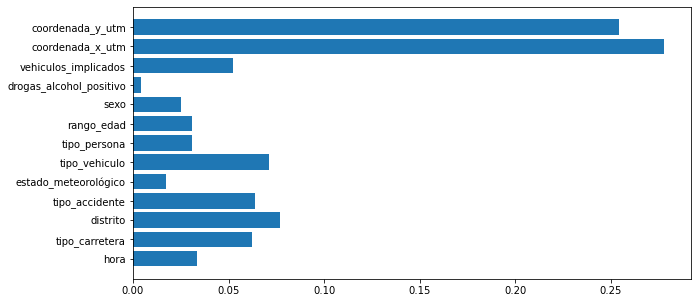

In [79]:
print(xgboost.get_booster().get_score(importance_type= 'weight'))
plt.figure(figsize=(10, 5))
plt.barh(X_train.columns, xgboost.feature_importances_)
plt.savefig('./madrid_v6.jpg')

print(xgboost.feature_importances_)

for column, weight in zip(X_train.columns,xgboost.feature_importances_):
  print(column, weight)

child_weights  = np.array(xgboost.feature_importances_)
feature_vector = fill_feature_vector(X_train, child_weights)

### Cálculo índices de matriz

In [80]:
matrix_indexes = fv2gi(feature_vector)

### Escritura

- v5: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades no están en rango.
- v6: Pesos calculados con hiperparámetros. En el dataset están tipificados los vehículos como en el artículo, las edades están en rango.
- v7: hiperparams, tipos de carretera tipificados por vía.

In [100]:
FILE_PATH = './XGBoost_Weights/'
FILE_NAME = 'madrid_weights' + MODEL_VERSION + '.json'
# FILE_NAME = 'default_calculated_weights.json'

write_weights(feature_vector, FILE_PATH, FILE_NAME)

In [82]:
matrix_indexes = fv2gi(feature_vector)

## Construcción de imágenes

In [83]:
train_bgi = build_gray_images(X_train, 5, matrix_indexes)
test_bgi  = build_gray_images(X_test, 5, matrix_indexes)

pd.DataFrame(train_bgi[:,:,1057])

127297
10877


,0,1,2,3,4
0,0.000000,0.000000,-0.019800,0.000000,0.000000
1,0.000000,-0.598557,-0.574697,0.000000,0.000000
2,-0.495443,0.465149,-0.638035,0.606803,-0.797175
3,0.166318,0.207526,-0.522965,-0.706410,0.000000
4,0.000000,0.000000,-0.336086,0.000000,0.000000


## Reshape de imágenes

<Figure size 432x288 with 0 Axes>

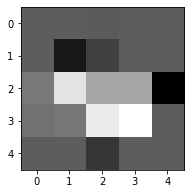

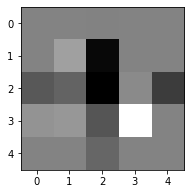

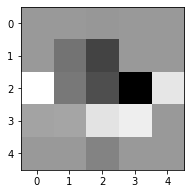

In [84]:
train_images = shape_images(X_data = X_train,
                            gray_images = train_bgi)
test_images  = shape_images(X_data = X_test,
                            gray_images = test_bgi)

plt.gray()
for i in range(0,3):
    plt.figure(figsize=(3, 3))
    plt.imshow(train_bgi[:,:,i])
    plt.show()

In [85]:
# train_images = shape_images(X_data = X_train,
#                             gray_images = train_bgi)
# test_images  = shape_images(X_data = X_test,
#                             gray_images = test_bgi)

## One-Hot

In [86]:
Y_train_onehot = casualty_to_one_hot(Y_train)
Y_test_onehot  = casualty_to_one_hot(Y_test)

array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

## Visualización de datos

In [87]:
# !conda install -c anaconda seaborn --y

### Matriz de correlación

In [88]:
# correlation_matrix(X_test)

### PCA

In [89]:
# pca(X_train, X_test)

### TSNE

In [90]:
# output_file_name = './2d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=2)

# output_file_name = './2d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=2)

# output_file_name = './3d_test_tsne.jpg'
# plot_TSNE(X_test, Y_test, n_components=3)

# output_file_name = './3d_train_tsne.jpg'
# plot_TSNE(X_train, Y_train, n_components=3)

### Autoencoder

#### Entrenamiento

In [91]:
# input_img = Input(shape=(25,))

# # definimos el encoder, que tendra una entrada de Input_img y una segunda capa con entrada de encoder1 y salida 3
# encoder1 = layers.Dense(15, activation='sigmoid')(input_img)
# encoder2 = layers.Dense(3, activation='sigmoid')(encoder1)

# # definimos el  decoder que tendra una entrada inicial de encoder3 y una salida de 128 y finalmete una capa de salida con los mismos que Input_img
# decoder1 = layers.Dense(15, activation='sigmoid')(encoder2)
# decoder2 = layers.Dense(25, activation='sigmoid')(decoder1)

# # this model maps an input to its reconstruction
# autoencoder = tf.keras.Model(inputs=input_img, outputs=decoder2)
# autoencoder.summary()

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #se usan estos dos en estas arquitecturas

X_train = array_train_images
X_test = array_test_images

X_train = X_train.reshape(len(array_train_images), 25)
X_test  = X_test.reshape(len(X_test), 25)

# autoencoder.fit(X_train, X_train,
#                 epochs=15,
#                 batch_size=32,
#                 shuffle=True,
#                 validation_data=(X_test, X_test))

#### Visualización

In [92]:
# # create encoder model
# encoder = tf.keras.Model(inputs=input_img, outputs=encoder2)
# encoder.summary()
# # create decoder model
# encoded_input = Input(shape=(3,))
# #lo que hace aqui es quedarse con las capas que corresponden al decodificador
# decoder_layer1 = autoencoder.layers[-2]
# decoder_layer2 = autoencoder.layers[-1]
# decoder = tf.keras.Model(inputs=encoded_input, outputs=decoder_layer2(decoder_layer1(encoded_input)))
# decoder.summary()
# # si miramos la salida, son simetricos el uno respecto al otro
# # encoder va de input a 3 y decoder de 3 a input

# # get latent vector for visualization
# latent_vector = encoder.predict(X_test)
# # get decoder output to visualize reconstructed image
# reconstructed_imgs = decoder.predict(latent_vector)


# # visualize in 3D plot
# from pylab import rcParams
# from mpl_toolkits.mplot3d import Axes3D

# rcParams['figure.figsize'] = 10, 8

# fig = plt.figure(1)
# ax = Axes3D(fig)

# xs = latent_vector[:, 0]
# ys = latent_vector[:, 1]
# zs = latent_vector[:, 2]

# # color=['red','green','blue']

# # for x, y, z, label in zip(xs, ys, zs, Y_test):
# #     c = color[int(label)]
# #     ax.text(x, y, z, label, backgroundcolor=c)
    
# # ax.set_xlim(xs.min(), xs.max())
# # ax.set_ylim(ys.min(), ys.max())
# # ax.set_zlim(zs.min(), zs.max())

# # plt.show()

# # X_test_encoded = encoder.predict(X_test, batch_size=32)
# # plt.figure(figsize=(6, 6))
# # plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test)
# # plt.colorbar()
# # plt.show()

## TASP-CNN

### Entrenamiento

In [93]:
array_train_images = np.asarray(train_images)
array_test_images  = np.asarray(test_images)

display(array_train_images.shape)
display(Y_train_onehot.shape)

display(array_test_images.shape)
display(Y_test_onehot.shape)

input_train_shape = (len(array_train_images), 5, 5, 1)
input_test_shape  = (len(array_test_images), 5, 5, 1)

array_train_images = array_train_images.reshape(input_train_shape)
array_test_images  = array_test_images.reshape(input_test_shape)


history = tasp_cnn.fit(array_train_images, Y_train_onehot, verbose=2,
                    batch_size = 128, epochs = 100, shuffle = True,
                    validation_data = (array_test_images, Y_test_onehot))


(127297, 5, 5, 1)

TensorShape([127297, 3])

(10877, 5, 5, 1)

TensorShape([10877, 3])

2022-04-04 13:28:33.659472: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-04 13:28:33.676616: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


Epoch 1/100


2022-04-04 13:28:34.891383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-04-04 13:28:35.299557: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2022-04-04 13:28:35.720494: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-04 13:28:36.067211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


995/995 - 30s - loss: 8.2928 - f1_score: 0.7220 - val_loss: 0.2505 - val_f1_score: 0.8949
Epoch 2/100
995/995 - 27s - loss: 0.2501 - f1_score: 0.8538 - val_loss: 427288.2500 - val_f1_score: 0.8112
Epoch 3/100
995/995 - 27s - loss: 251.9184 - f1_score: 0.6303 - val_loss: 0.8148 - val_f1_score: 0.6098
Epoch 4/100
995/995 - 27s - loss: 0.7216 - f1_score: 0.6345 - val_loss: 3460.2295 - val_f1_score: 0.6198
Epoch 5/100
995/995 - 27s - loss: 0.6346 - f1_score: 0.6814 - val_loss: 20814.8242 - val_f1_score: 0.6182
Epoch 6/100
995/995 - 27s - loss: 20.7897 - f1_score: 0.6966 - val_loss: 1.4145 - val_f1_score: 0.6623
Epoch 7/100
995/995 - 27s - loss: 0.4281 - f1_score: 0.7627 - val_loss: 8813538.0000 - val_f1_score: 0.5889
Epoch 8/100
995/995 - 27s - loss: 366.2893 - f1_score: 0.7386 - val_loss: 1.5948 - val_f1_score: 0.6246
Epoch 9/100
995/995 - 27s - loss: 0.8228 - f1_score: 0.7069 - val_loss: 77478.0469 - val_f1_score: 0.6557
Epoch 10/100
995/995 - 27s - loss: 1.9429 - f1_score: 0.7028 - val_

### Escritura del modelo

In [98]:
tasp_cnn.save(root_path + 'madrid_model_bayesian' + MODEL_VERSION + '.h5')

### Carga de modelo pre-entrenado

In [95]:
# tasp_cnn = tf.keras.models.load_model(root_path + 'madrid_model_bayesian' + MODEL_VERSION + '.h5')

### Resultados

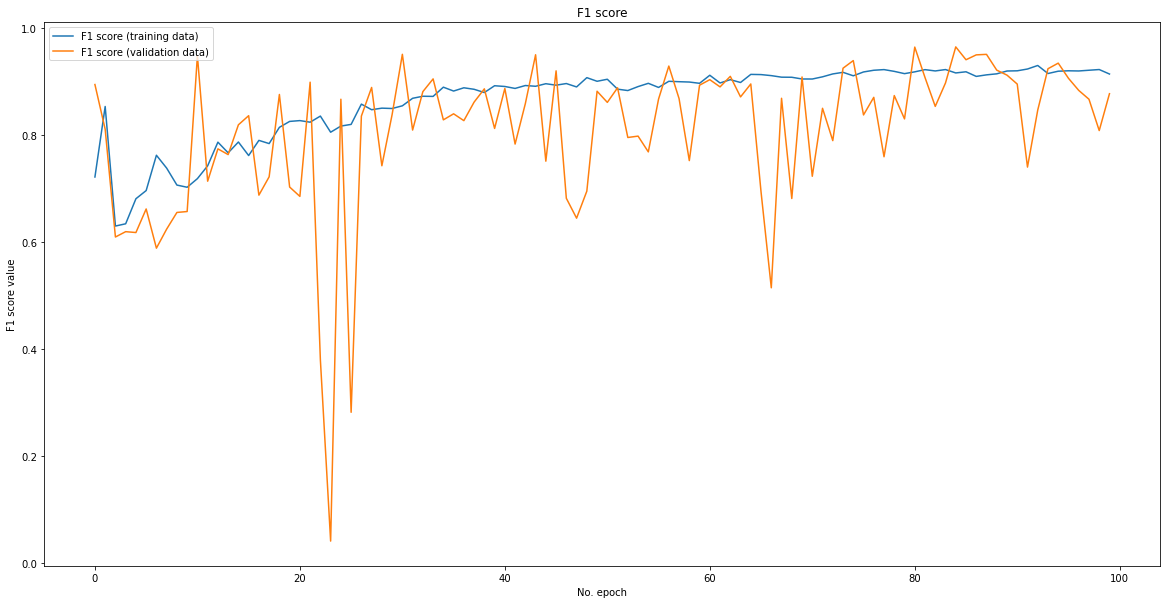

[INFO] evaluating network...


,precision,recall,f1-score,support
Slight,0.983528,0.890084,0.934476,10599.000000
Serious,0.086614,0.423077,0.143791,260.000000
Fatal,0.000000,0.000000,0.000000,18.000000
accuracy,0.877448,0.877448,0.877448,0.877448
macro avg,0.356714,0.437720,0.359422,10877.000000
weighted avg,0.960461,0.877448,0.914029,10877.000000


In [99]:
from sklearn.metrics import classification_report

Y_test_labels = one_hot_to_casualty(Y_test)

########################################################################

F1_SCORE_PATH = 'F1scores/'
F1_SCORE_NAME = 'score' + MODEL_VERSION

## Plot history: F1 SCORE
figure_name = plt.figure(figsize=(20, 10))
plt.plot(history.history['f1_score'], label='F1 score (training data)')
plt.plot(history.history['val_f1_score'], label='F1 score (validation data)')
plt.title('F1 score')
plt.ylabel('F1 score value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig(F1_SCORE_PATH + F1_SCORE_NAME + '.jpg')
plt.show()

print(history)

########################################################################

# evaluate the network
print("[INFO] evaluating network...")
predictions = tasp_cnn.predict(x=array_test_images, batch_size=128)

report = classification_report(tf.argmax(Y_test_onehot, axis=1),
                               predictions.argmax(axis=1),
                               target_names = Y_test_labels.unique(),
                               output_dict = True)

REPORTS_PATH = 'Reports/'
REPORT_NAME  = 'Report' + MODEL_VERSION + '.csv'

report_df = pd.DataFrame(report).transpose()
report_df.to_csv(REPORTS_PATH + REPORT_NAME, index= True)

report_df

In [97]:
# tasp_cnn.save(root_path + 'madrid_model_XGBOOST_predicted.h5')